# Problema

O problema de Detecção de Fraude em Cartões de Crédito envolve modelar transações passadas de cartões de crédito com o conhecimento das que se revelaram fraudulentas. Esse modelo é então usado para identificar se uma nova transação é fraudulenta ou não. Nosso objetivo aqui é detectar 100% das transações fraudulentas enquanto minimizamos as classificações incorretas de fraude.

# Perguntas de Negócio

Como todas as variáveis são anônimas, vamos focar nossa análise nas variáveis não anonimizadas: Tempo e Valor.

Quão diferente é o valor do dinheiro utilizado em diferentes classes de transações?

As transações fraudulentas ocorrem com mais frequência durante determinados períodos?

##### Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.warn('ignore', FutureWarning)

%matplotlib inline
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

## Exploratory Data Analysis (EDA)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
### Diminuindo os decimais
pd.set_option("display.float", "{:.2f}".format)
df.describe()

Verificando os valores ausentes/nulos do dataset.

In [8]:
df.isnull().sum().sum()

0

In [9]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

As únicas variáveis não transformadas para trabalhar são:
Tempo, Valor, Classe (1: fraude, 0: não fraude)

Text(0, 0.5, 'Frequencia')

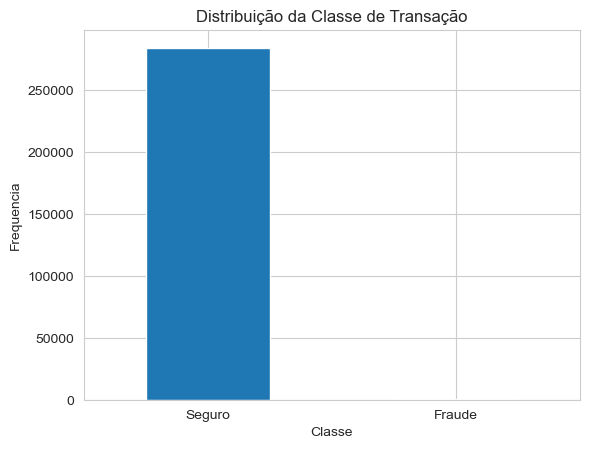

In [11]:
labels = ["Seguro", "Fraude"]

count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Distribuição da Classe de Transação")
plt.xticks(range(2), labels)
plt.xlabel("Classe")
plt.ylabel("Frequencia")

Podemos ver que neste conjunto de dados são poucas as transações que são realmente fraudulentas.

In [12]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

É importante notar que o conjunto de dados original apresenta um desequilíbrio significativo, a maioria das transações não é fraudulenta. Se utilizarmos este dataframe como base para nossos modelos preditivos e análises é provável que enfrentemos uma alta taxa de erros. Além disso, nossos algoritmos podem sofrer overfitting, uma vez que tenderão a 'assumir' que a maioria das transações não é fraude.

# Análise Estatística

Para lidar com outliers, usaremos o IQR (Intervalo Interquartílico), no qual eliminaremos os outliers que estão abaixo do 10º percentil ou acima do 90º percentil.

In [13]:
Q1 = df.quantile(0.25)
Q2 = df.quantile(0.75)
IQR = Q2-Q1
print("IQR of whole dataset: ")
print(IQR)

IQR of whole dataset: 
Time      85119.000000
V1            2.236015
V2            1.402274
V3            1.917560
V4            1.591981
V5            1.303524
V6            1.166861
V7            1.124512
V8            0.535976
V9            1.240237
V10           0.989349
V11           1.502088
V12           1.023810
V13           1.311044
V14           0.918724
V15           1.231705
V16           0.991333
V17           0.883423
V18           0.999657
V19           0.915248
V20           0.344762
V21           0.414772
V22           1.070904
V23           0.309488
V24           0.794113
V25           0.667861
V26           0.567936
V27           0.161885
V28           0.131240
Amount       71.565000
Class         0.000000
dtype: float64


In [14]:
print("Skewness of the data: ")
df_skew = df.skew()
print(df_skew)

Skewness of the data: 
Time      -0.035568
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
Class     23.997579
dtype: float64


### Box Plot dos dados

Detecting Outilers:
 


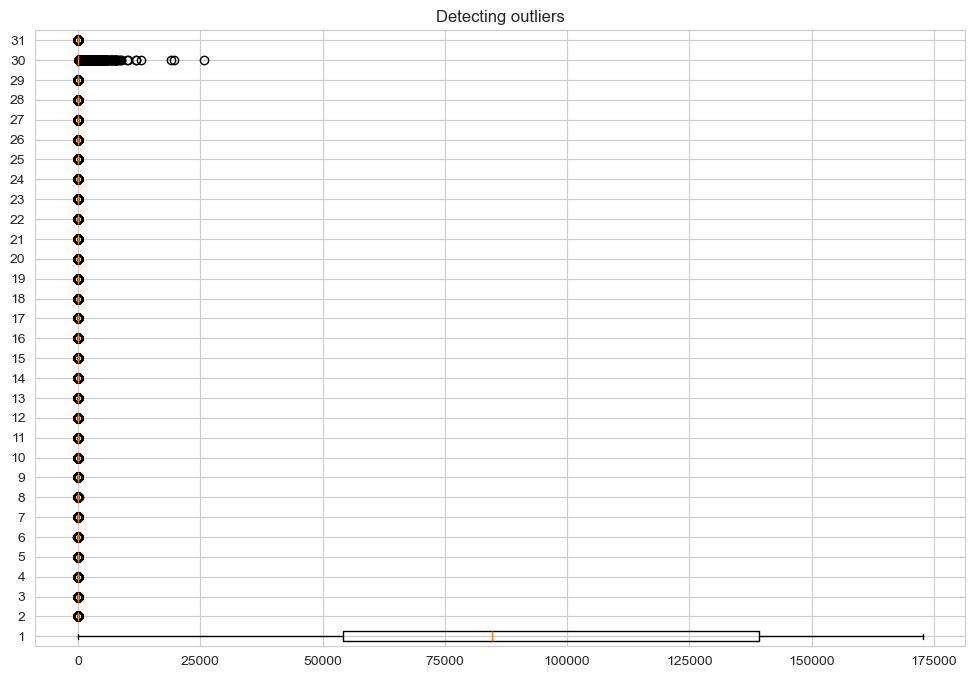

In [15]:
print("Detecting Outilers:\n ")
plt.figure(figsize=(12,8))
plt.boxplot(df, vert=False)
plt.title("Detecting outliers")
plt.show()

O eixo y de Tempo e Valor está exibindo outliers; vamos verificar esses casos

Time Column
Detecting Outilers:
 


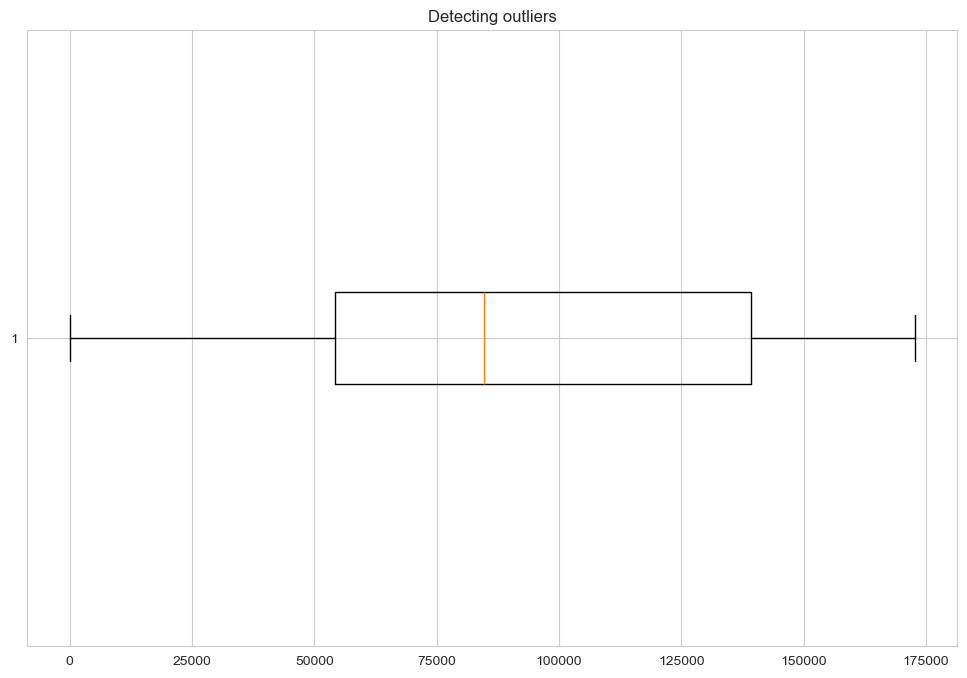

In [16]:
def box_out(df):
    print("Detecting Outilers:\n ")
    plt.figure(figsize=(12,8))
    plt.boxplot(df, vert=False)
    plt.title("Detecting outliers")
    plt.show()
    
print("Time Column")
box_out(df['Time'])

Não há problema na coluna Tempo.

##### Analisando a variável "Amount" para uma melhor compreensão do Valor.

In [17]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

Outliers of Amount: :
Detecting Outilers:
 


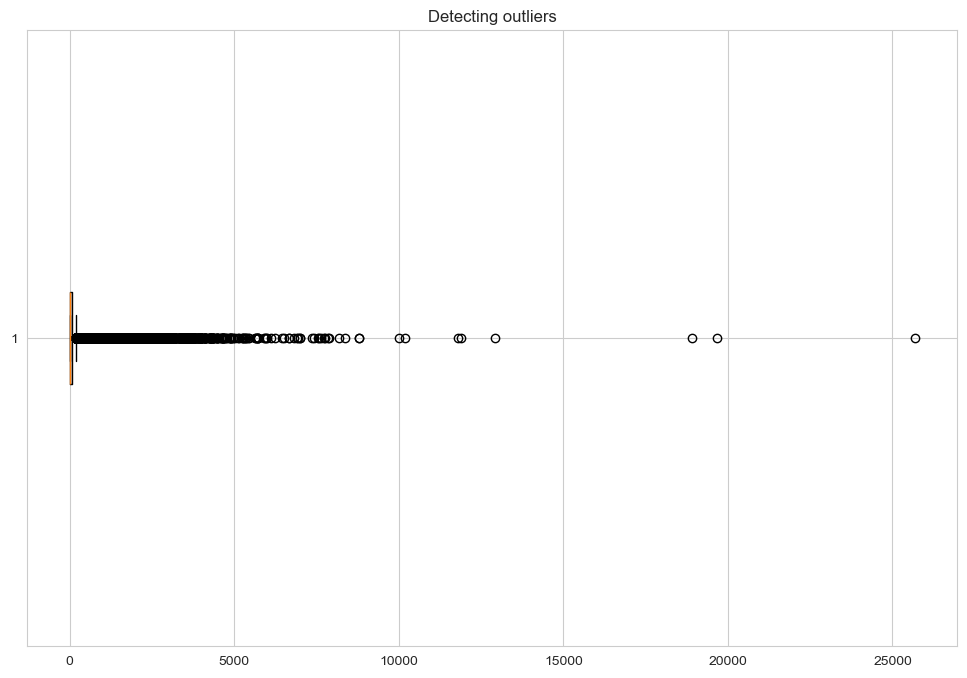

In [18]:
print("Outliers of Amount: :")
box_out(df['Amount']) 

Há uma quantidade significativa de outliers na coluna "Amount". A coluna "Amonut" é muito importante para estes dados. 

A imagem acima mostra que, após o valor 900, há outliers distribuídos até mais de 25.000.

# Removendo outliers

In [19]:
print("10th percentile of Amount: ")
print(df["Amount"].quantile(0.10))
print("90th percentile of price: ")
print(df["Amount"]. quantile(0.90))

10th percentile of Amount: 
1.0
90th percentile of price: 
203.0


Com base nos percentis (10º e 90º), podemos remover os pontos de dados que estão fora desse intervalo, mas pode ser que não haja outliers abaixo do 10º percentil. 

Portanto, vamos remover os outliers que estão acima do 90º percentil e plotar um gráfico de caixa para verificar se há outliers abaixo do 10º percentil.

After removing outliers >90th percentile: :
Detecting Outilers:
 


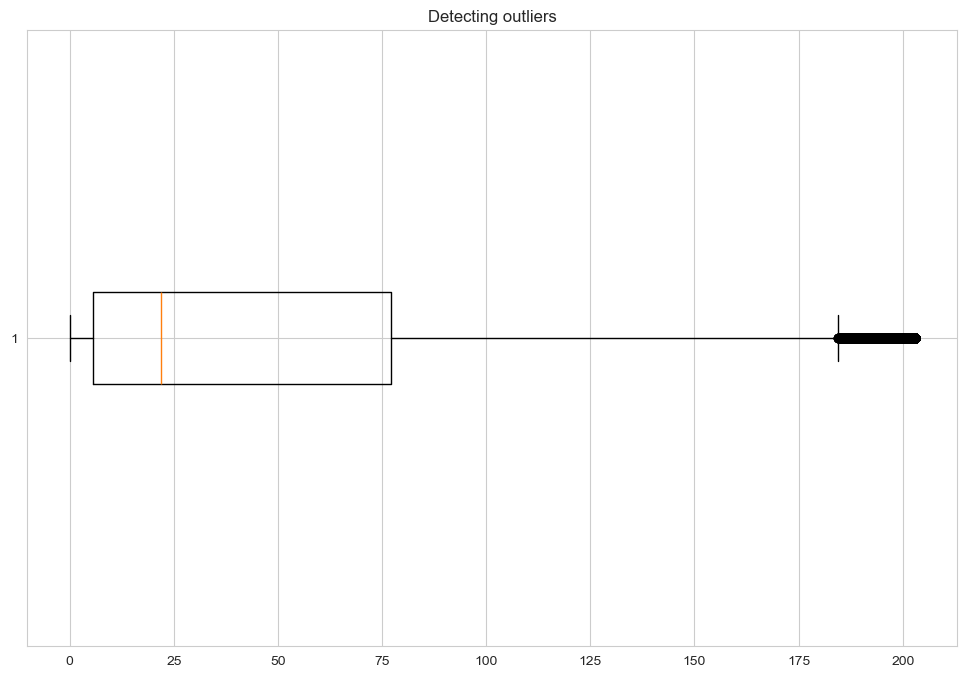

In [20]:
df['Amount'] = np.where(df['Amount']>203.0, 203.0, df['Amount'])

print("After removing outliers >90th percentile: :")
box_out(df['Amount'])

Eliminado a maioria dos outliers que estavam acima do 90º percentil dos dados.

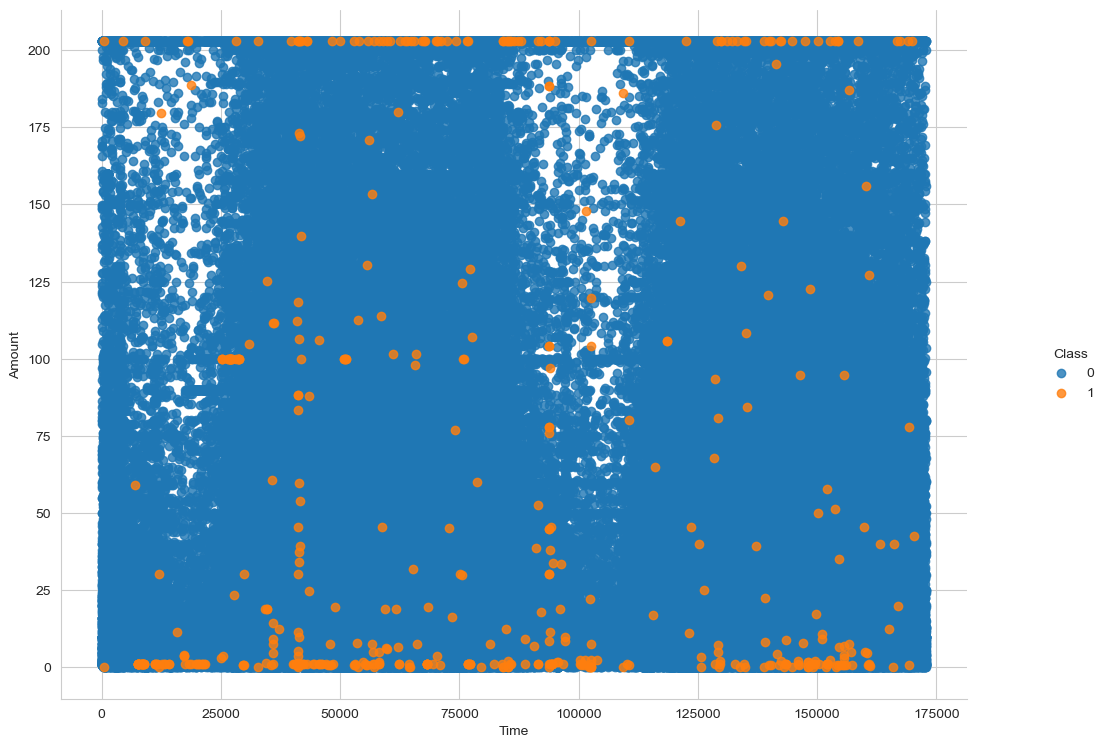

In [22]:
sns.lmplot(x='Time', y='Amount', data=df, hue='Class', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

In [23]:
fraud = df[df['Class']==1]
safe = df[df['Class']==0]

print(f"Shape of Fraudlent transactions: {fraud.shape}")
print(f"Shape of Non-Fraudlent transactions: {safe.shape}")

Shape of Fraudlent transactions: (492, 31)
Shape of Non-Fraudlent transactions: (284315, 31)


##### Qual é a diferença no valor do dinheiro utilizado em diferentes classes de transações?

In [24]:
pd.concat([fraud.Amount.describe(), safe.Amount.describe()], axis=1)

,Amount,Amount
count,492.000000,284315.000000
mean,61.823333,53.680171
std,78.302152,65.992302
min,0.000000,0.000000
25%,1.000000,5.650000
50%,9.250000,22.000000
75%,105.890000,77.050000
max,203.000000,203.000000


##### As transações fraudulentas ocorrem com mais frequência em determinados períodos de tempo?

In [25]:
pd.concat([fraud.Time.describe(), safe.Time.describe()], axis=1)

,Time,Time
count,492.000000,284315.000000
mean,80746.806911,94838.202258
std,47835.365138,47484.015786
min,406.000000,0.000000
25%,41241.500000,54230.000000
50%,75568.500000,84711.000000
75%,128483.000000,139333.000000
max,170348.000000,172792.000000


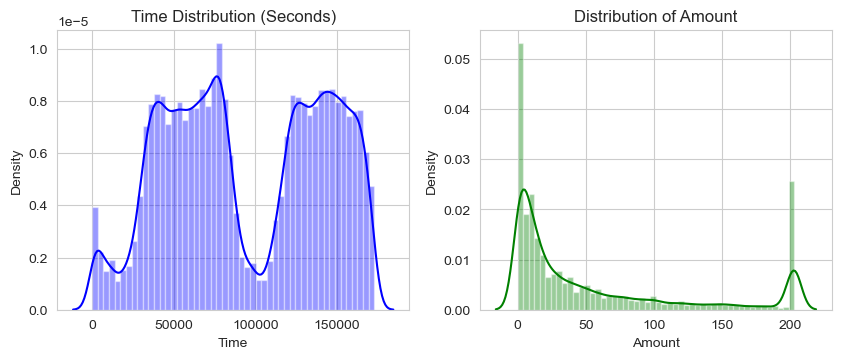

In [29]:
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.title('Time Distribution (Seconds)')

sns.distplot(df['Time'], color='blue');


plt.subplot(2, 2, 2)
plt.title('Distribution of Amount')
sns.distplot(df['Amount'],color='green');

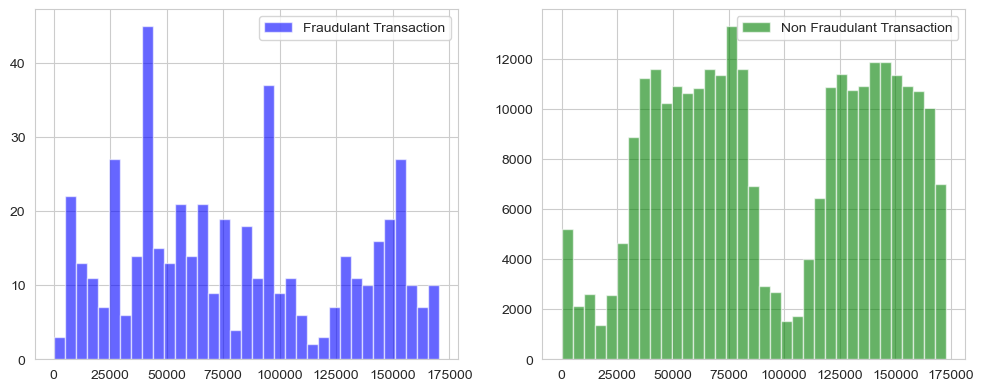

In [30]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df[df.Class == 1].Time.hist(bins=35, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.legend()

plt.subplot(2, 2, 2)
df[df.Class == 0].Time.hist(bins=35, color='green', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend()

Observando as distribuições, podemos ter uma ideia de quão enviesadas estão essas variáveis. Também podemos analisar as distribuições de outras variáveis. Existem técnicas que podem ajudar a tornar as distribuições menos enviesadas, as quais serão implementadas neste notebook no futuro.

Parece que o horário da transação não tem muita importância aqui, conforme a observação acima. Agora, vamos pegar uma amostra do conjunto de dados para nossa modelagem e previsão.

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

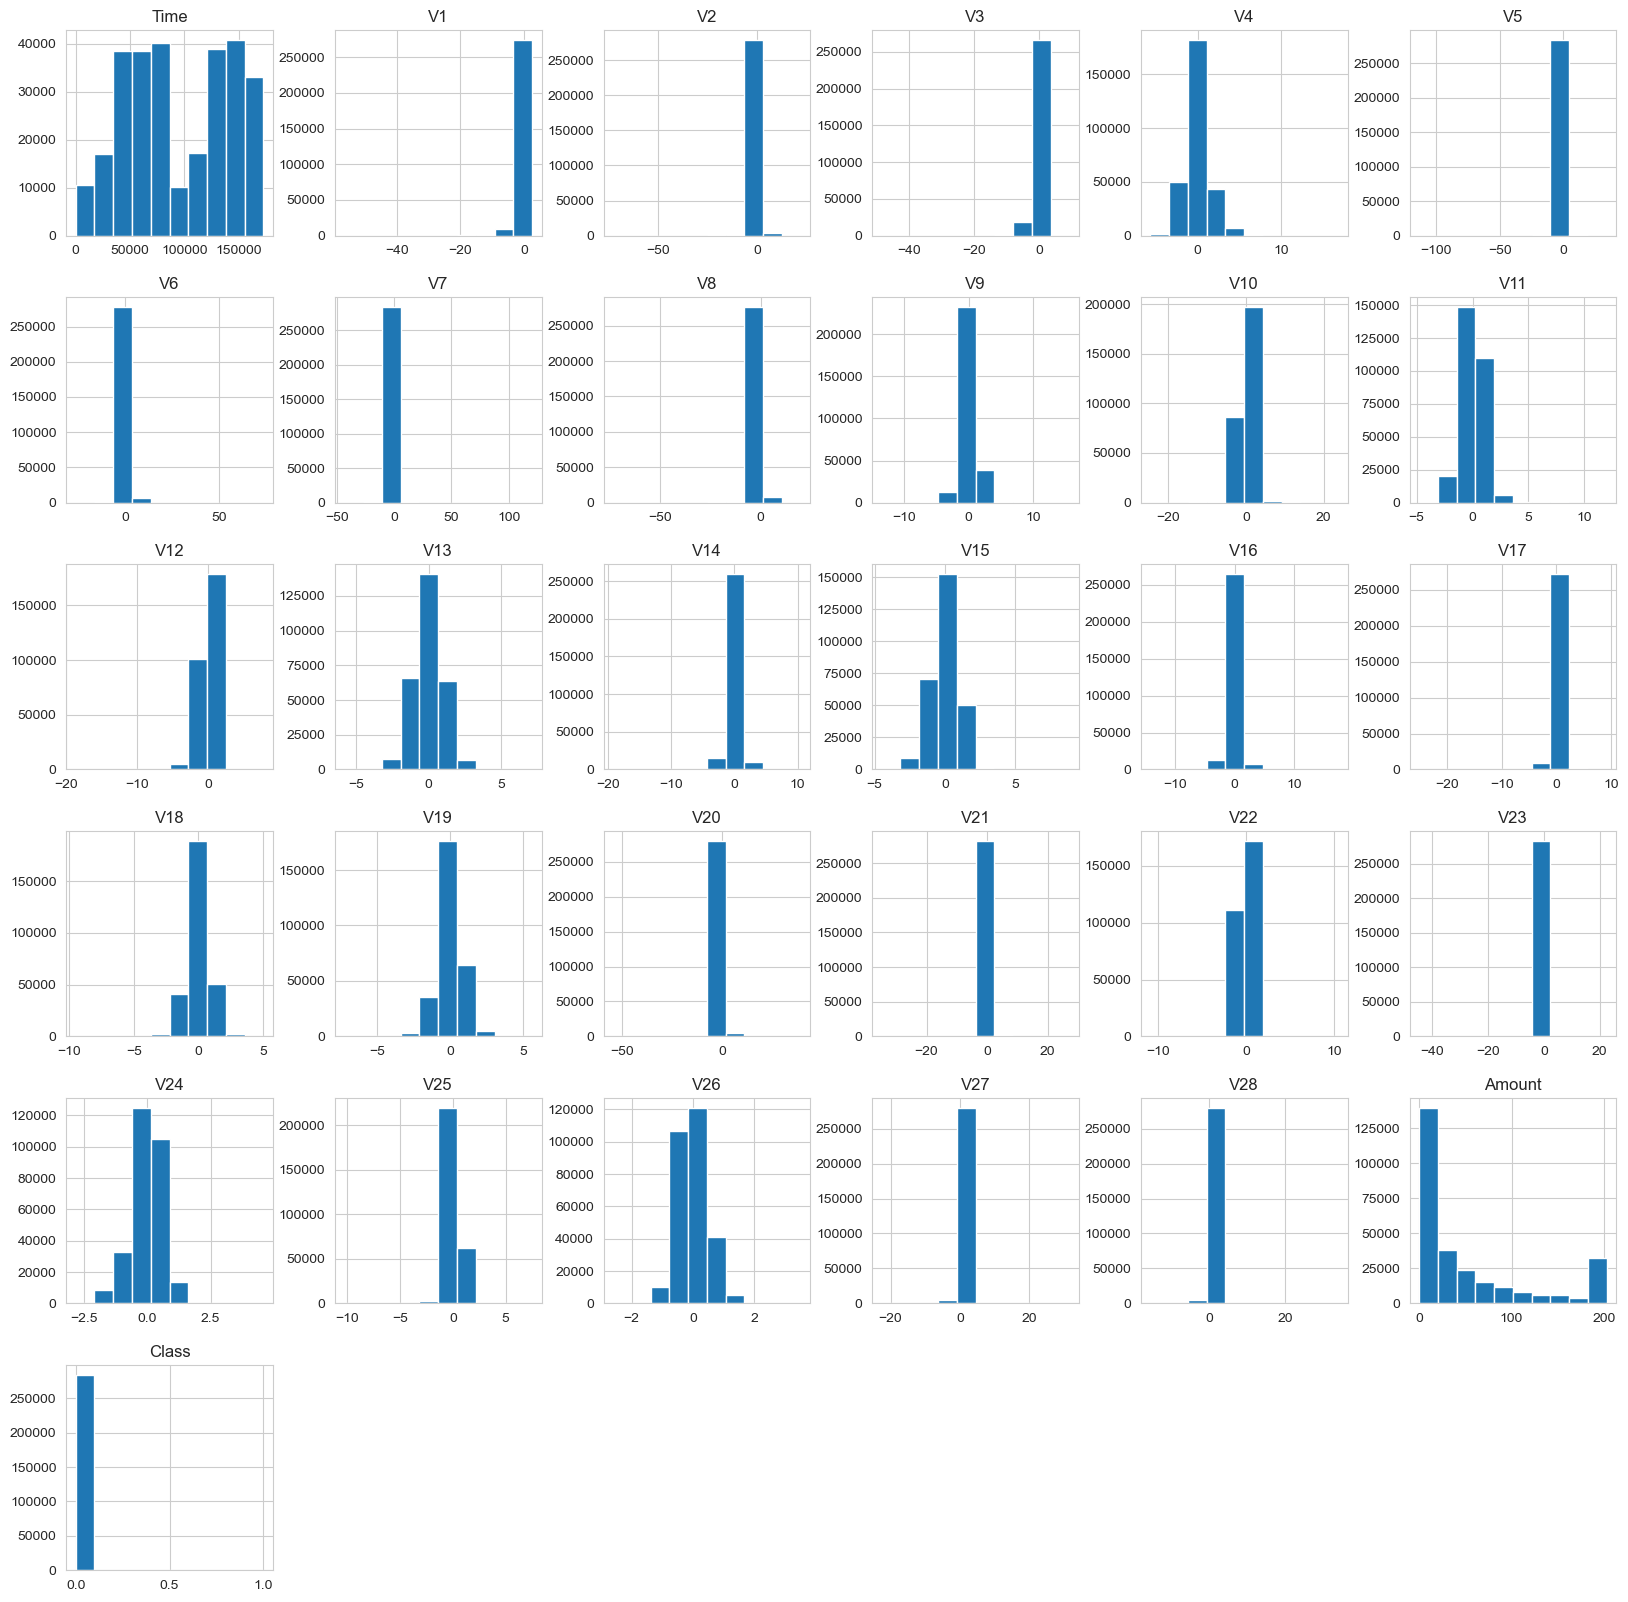

In [31]:
df.hist(figsize=(20,20))

In [32]:
df.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.023155,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.115345,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.445037,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.076982,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.011243,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.271441,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.144382,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.122068,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.035477,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.053642,-0.097733


Vamos encontrar altas correlações.

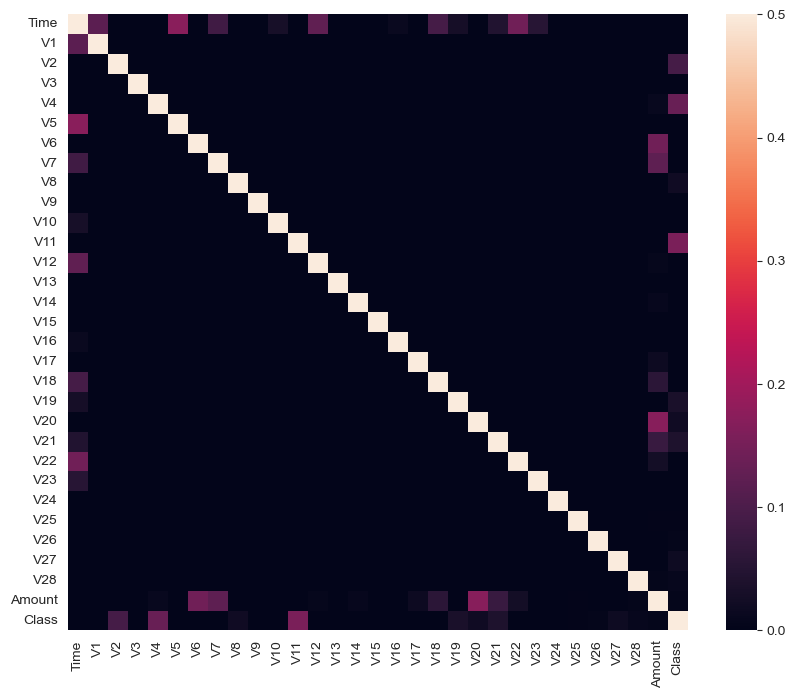

In [34]:
plt.figure(figsize=(10,8))
sns.heatmap(data=df.corr(), vmin=0,vmax=0.5, annot=False)
plt.show()

As maiores correlações são:

Time & V3 (-0,42)

Amount & V2 (-0,53)

Amount & V4 (0,4)

Embora essas correlações sejam altas, não espero que haja risco de multicolinearidade.

A matriz de correlação também mostra que nenhuma das componentes PCA de V1 a V28 tem correlação entre si. No entanto, observamos que a Class tem algumas correlações positivas e negativas com as componentes V, mas não tem correlação com Time e Amount.

# Processamento de Dados

Time e Amount devem ser escalados como as outras colunas.

Dividindo o conjunto de dados em treino e teste.

In [35]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
print(X.shape, X_train.shape, X_test.shape)

(284807, 30) (199364, 30) (85443, 30)


##### Standardization

In [37]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Treinamento do Modelo de Machine Learning

##### XGBoost

Obs(Se o modelo não treinar bem com os algoritmos acima, então podemos treinar com uma Rede Neural Artificial (ANN))

In [40]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 1.7 MB/s eta 0:01:14
   ---------------------------------------- 0.2/124.9 MB 1.5 MB/s eta 0:01:25
   ---------------------------------------- 0.4/124.9 MB 2.4 MB/s eta 0:00:51
   ---------------------------------------- 0.5/124.9 MB 2.4 MB/s eta 0:00:52
   ---------------------------------------- 0.7/124.9 MB 2.7 MB/s eta 0:00:46
   ---------------------------------------- 0.8/124.9 MB 2.7 MB/s eta 0:00:47
   ---------------------------------------- 1.0/124.9 MB 2.8 MB/s eta 0:00:44
   ---------------------------------------- 1.2/124.9 MB 3.0 MB/s eta 0:00:42
   ---------------------------------------- 1.4/124.9 MB 3.1 MB/s eta 0:00:40
    --------------------------------------- 1.7/124.9 MB 3.3 MB/s eta 0:00:38
    --------------------------------------- 1.8/124.9 MB 3.3 MB/s eta 0:00:38


## XGBClassifier

In [41]:
print("Training with XGBoost Classifier: ")
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

print("\nScore of XGBClassifier: ")
xgb.score(X_train, y_train)

Training with XGBoost Classifier: 

Score of XGBClassifier: 


1.0

# Avaliação do Modelo

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [43]:
train_pred = xgb.predict(X_train)
print(accuracy_score(train_pred, y_train))

1.0


In [44]:
test_pred = xgb.predict(X_test)
print(accuracy_score(test_pred, y_test))

0.9996371850239341


##### Classification Report

In [45]:
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85324
           1       0.82      0.94      0.88       119

    accuracy                           1.00     85443
   macro avg       0.91      0.97      0.94     85443
weighted avg       1.00      1.00      1.00     85443



##### Confusion Matrix

In [51]:
cm = confusion_matrix(y_test, test_pred)
print("Confusion Matrix : \n", cm)


Confusion Matrix : 
 [[85300     7]
 [   24   112]]


### Esse modelo teve um desempenho muito bom para este problema.